# Dogs vs. Cats
In this project, I use a convolutional neural network to distinguish dogs from cats. The dataset used in this project is the training dataset from the "Dogs vs. Cats" Kaggle competition:
https://www.kaggle.com/c/dogs-vs-cats

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as activation
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
# This is only needed in google colaboratory to download training
# data from google drive to the system
!unzip "drive/MyDrive/Computer Vision/Dogs vs. Cats/train.zip"
from google.colab import output
output.clear()
print("Done!")

Done!


In [3]:
# Setting up device
# If there is a GPU, training will be faster
device = None

if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")

print(device)

cuda:0


In [4]:
# Dataset class to manage images
class DogsVsCatsDataset(Dataset):

    CAT = "cat"
    DOG = "dog"
    Labels = {CAT: 0, DOG: 1}

    def __init__(self):

        self.x = []
        self.y = []
        self.length = 0

        for image_name in os.listdir("train"):

            path = os.path.join("train", image_name)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (50, 50))
            image = image / 255.0
            self.x.append(image.reshape((1, 50, 50)))

            if self.CAT in image_name:
                self.y.append(self.Labels[self.CAT])

            elif self.DOG in image_name:
                self.y.append(self.Labels[self.DOG])

            self.length += 1
        
        self.x = torch.from_numpy(np.stack(self.x)).double()
        self.y = torch.from_numpy(np.array(self.y)).double()
        self.y = self.y.view(-1, 1).double()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.length

In [5]:
# Convolutional neural network class
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.pool3 = nn.MaxPool2d(2, 2)
        self.l1 = nn.Linear(2048, 16)
        self.l2 = nn.Linear(16, 8)
        self.l3 = nn.Linear(8, 1)

    def forward(self, x):
        x = activation.relu(self.conv1(x))
        x = self.pool(x)
        x = activation.relu(self.conv2(x))
        x = self.pool2(x)
        x = activation.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(1000, -1)
        x = activation.relu(self.l1(x))
        x = activation.relu(self.l2(x))
        # Sigmoid function returns a probability 
        # of the image being an image of a dog
        y = torch.sigmoid(self.l3(x))
        return y

In [6]:
# Hyperparameters for training model
batch_size = 1000
learning_rate = 0.003
number_of_epochs = 50

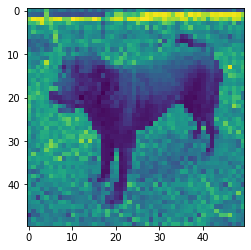

1.0


In [7]:
# The dataset is split into training and validation datasets
dataset = DogsVsCatsDataset()
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [20000, 5000])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
image, label = dataset[0]
plt.imshow(image.numpy().reshape((50, 50)))
plt.show()
print(label.item())

In [8]:
model = ConvNet().double().to(device)
# Binary cross entropy loss is used as there is only one probability
# value being outputed from the model
criterion = nn.BCELoss()
# Adam optimizer is used
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=2048, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=1, bias=True)
)


In [9]:
training_losses = []
validation_losses = []

for epoch in range(1, number_of_epochs + 1):

    training_loss = 0
    validation_loss = 0

    for features, labels in train_loader:
        output = model(features.to(device)).to(device)
        loss = criterion(output, labels.to(device)).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    
    with torch.no_grad():
        for features, labels in validation_loader:
            output = model(features.to(device)).to(device)
            loss = criterion(output, labels.to(device))
            validation_loss += loss.item()

    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    print(f"Epoch: {epoch}/{number_of_epochs}, training loss: {training_loss:.4f}, validation loss: {validation_loss:.4f}")

Epoch: 1/50, training loss: 14.0139, validation loss: 3.4581
Epoch: 2/50, training loss: 13.8240, validation loss: 3.4373
Epoch: 3/50, training loss: 13.6508, validation loss: 3.3546
Epoch: 4/50, training loss: 13.4632, validation loss: 3.2581
Epoch: 5/50, training loss: 13.1089, validation loss: 3.2118
Epoch: 6/50, training loss: 12.8235, validation loss: 3.1504
Epoch: 7/50, training loss: 12.5332, validation loss: 3.0581
Epoch: 8/50, training loss: 12.1370, validation loss: 2.9993
Epoch: 9/50, training loss: 11.7379, validation loss: 2.8658
Epoch: 10/50, training loss: 11.3849, validation loss: 2.7759
Epoch: 11/50, training loss: 10.8908, validation loss: 2.6673
Epoch: 12/50, training loss: 10.6357, validation loss: 2.6077
Epoch: 13/50, training loss: 10.3794, validation loss: 2.5930
Epoch: 14/50, training loss: 10.2082, validation loss: 2.5345
Epoch: 15/50, training loss: 9.9665, validation loss: 2.5138
Epoch: 16/50, training loss: 9.7198, validation loss: 2.5270
Epoch: 17/50, train

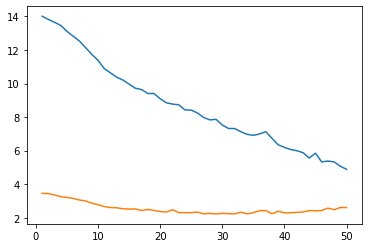

In [10]:
# Graph of loss is plotted to ensure that there is no overfitting
import matplotlib.pyplot as plt
plt.plot([epoch for epoch in range(1, number_of_epochs + 1)], training_losses)
plt.plot([epoch for epoch in range(1, number_of_epochs + 1)], validation_losses)

In [11]:
# Accuracy of the model is calculated
model = model.eval()

with torch.no_grad():

    train_counter = 0

    for features, labels in train_loader:

        result = model(features.to(device))

        for result_one, label_one in zip(result, labels):

            if result_one[0] > 0.5 and int(label_one[0]) == 1:
                train_counter += 1

            if result_one[0] < 0.5 and int(label_one[0]) == 0:
                train_counter += 1
        
    print(f"Training accuracy: {train_counter / 20000:.2%}")
    
with torch.no_grad():

    validation_counter = 0

    for features, labels in validation_loader:

        result = model(features.to(device))

        for result_one, label_one in zip(result, labels):

            if result_one[0] > 0.5 and int(label_one[0]) == 1:
                validation_counter += 1

            if result_one[0] < 0.5 and int(label_one[0]) == 0:
                validation_counter += 1
        
    print(f"Validation accuracy: {validation_counter / 5000:.2%}")

Training accuracy: 90.20%
Validation accuracy: 79.98%
